# Численные методы решения дифференциальных уравнений с частными производными.

In [1]:
import math
import numpy as np
import matplotlib.cm
import matplotlib.pyplot as plt

Вспомогательные константы и функции

In [2]:
! make compile

g++ -g -pedantic -std=c++17 -Wall -Wextra -Werror main.cpp -o solver


In [3]:
EPS = 1e-9

def neq(x, y):
    return True if np.abs(x - y) > EPS else False

def write_arr(file, arr):
    file.write(" ".join(str(elem) for elem in arr) + "\n")

### Ввод данных

Критерий КФЛ (критерий Куранта-Фридрихса-Леви)

In [4]:
sigma = 0.5

Используемый численный метод

* $\theta = 0$ - явный метод
* $\theta = {1 \over 2}$ - комбинированный метод Кранка-Николсона
* $\theta = 1$ - неявный метод

In [5]:
theta = 0.5

Ограничения по $x$ и $t$, параметр сетки.

$x \in [0, l]$, $t \in [0, T]$

In [6]:
l = 1
n = 100
T = 0.3

Коэффициенты уравнения

In [7]:
a = 1
b = 0
c = 0

Граничные условия

In [8]:
def ux0(x, t):
    if (neq(t, 0)):
        raise BaseException("Ошибка")
    return np.sin(np.pi * x)

def ult(x, t):
    if (neq(x, l)):
        raise BaseException("Ошибка")
    return 0.0

def u0t(x, t):
    if (neq(x, 0)):
        raise BaseException("Ошибка")
    return 0.0

Точное решение

In [9]:
def true_u(x, t):
    return np.exp(-np.pi ** 2 * t * a) * np.sin(np.pi * x)

### Препроцессинг

Вычисление шагов $h$ и $\tau$

In [10]:
K = math.ceil((T * a * n * n) / (l * l * sigma))

h = l / (n - 1)
tau = T / (K - 1)

t = [k * tau for k in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * h for i in range(n - 1)]
x.append(l)
x = np.array(x)

Генерация узлов сетки

In [11]:
t = [k * tau for k in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * h for i in range(n - 1)]
x.append(l)
x = np.array(x)

Генерация начальных условий для решателя

In [12]:
u_left = []
u_low = []
u_right = []

for i in range(n):
    u_low.append(ux0(x[i], 0))

for k in range(K):
    u_left.append(u0t(0, t[k]))
    u_right.append(ult(l, t[k]))

if (neq(u_low[0], u_left[0])):
    raise BaseException("Ошибка в граничных условиях слева")

if (neq(u_low[-1], u_right[0])):
    raise BaseException("Ошибка в граничных условиях справа")

with open("in.txt", "w") as file_in:
    write_arr(file_in, [n, K])
    write_arr(file_in, [l, T, h, tau, theta])
    write_arr(file_in, [a, b, c])
    write_arr(file_in, u_low)
    write_arr(file_in, u_left)
    write_arr(file_in, u_right)

### Решение

In [13]:
! ./solver < in.txt > out.txt

### Постпроцессинг

In [14]:
data = []

with open("out.txt", "r") as file_out:
    for _ in range(K):
        file_line = file_out.readline()
        data_line = [float(elem) for elem in file_line.split()]
        data.append(data_line)

data = np.array(data)

### Визуализация

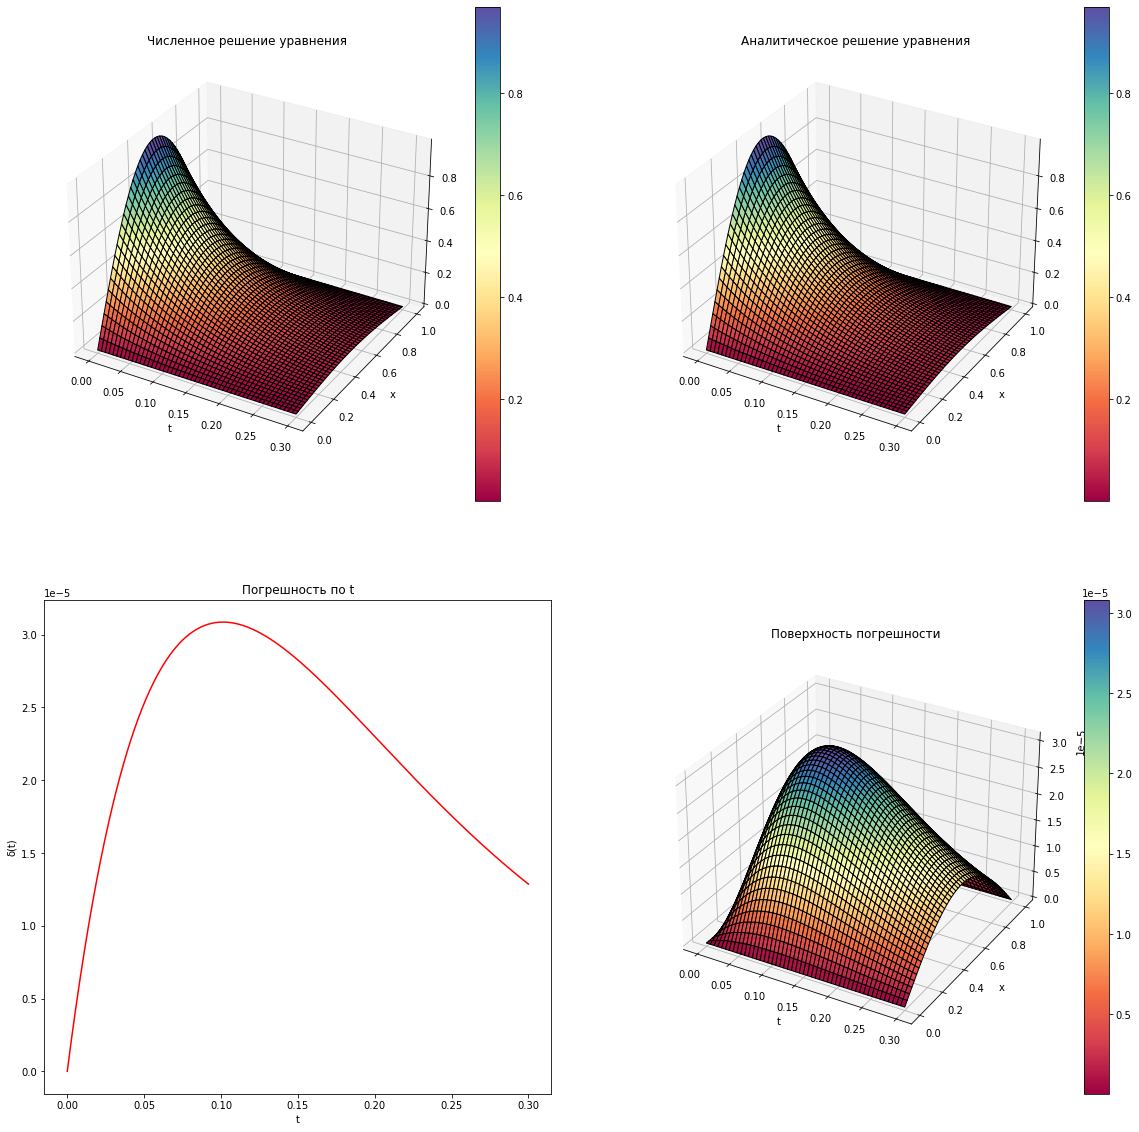

In [15]:
def subplot3d(ind, figure, x, y, z):
    axes = figure.add_subplot(ind, projection = "3d")
    surface = axes.plot_surface(x, y, z, edgecolors = ["black"], linewidth = 1,
                                cmap = matplotlib.cm.Spectral, shade = True, antialiased = True)
    figure.colorbar(surface)

figure = plt.figure(figsize = (20, 20))
x_plt, t_plt = np.meshgrid(x, t)
true_data = true_u(x_plt, t_plt)
delta = np.abs(data - true_data)

subplot3d(221, figure, t_plt, x_plt, data)
plt.title("Численное решение уравнения")
plt.xlabel("t")
plt.ylabel("x")

subplot3d(222, figure, t_plt, x_plt, true_data)
plt.title("Аналитическое решение уравнения")
plt.xlabel("t")
plt.ylabel("x")

axes = figure.add_subplot(223)
axes.plot(t, np.max(delta, axis = 1), color = "red")
plt.title("Погрешность по t")
plt.xlabel("t")
plt.ylabel("δ(t)")

subplot3d(224, figure, t_plt, x_plt, delta)
plt.title("Поверхность погрешности")
plt.xlabel("t")
plt.ylabel("x")
plt.show()